In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset

 90% 93.0M/103M [00:00<00:00, 215MB/s]
100% 103M/103M [00:00<00:00, 186MB/s] 


In [ ]:
#extracting files 
from zipfile import ZipFile

with ZipFile('mango-leaf-disease-dataset.zip', 'r') as f:

 #extract in different directory
 f.extractall('images')

In [ ]:
import os
import shutil
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import cv2

root_directory = "/content/images" 
train_ratio = 0.7  
val_ratio = 0.15  
test_ratio = 0.15  

subfolders = [f.name for f in os.scandir(root_directory) if f.is_dir()]

for subfolder in subfolders:
    subfolder_path = os.path.join(root_directory, subfolder)
    images = [f.name for f in os.scandir(subfolder_path) if f.is_file()]

    random.shuffle(images)

    num_images = len(images)
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val

    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    train_dir = os.path.join(root_directory, 'train', subfolder)
    val_dir = os.path.join(root_directory, 'val', subfolder)
    test_dir = os.path.join(root_directory, 'test', subfolder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for image in train_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(train_dir, image)
        shutil.move(src, dst)

    for image in val_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(val_dir, image)
        shutil.move(src, dst)

    for image in test_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(test_dir, image)
        shutil.move(src, dst)

    os.rmdir(subfolder_path) #deleting empty folders

In [ ]:
#optional code for debugging- can be excluded
#testing whether the subfolders are formed after the above action
data_dir_of_test = '../content/images/test'
print(os.listdir(data_dir))

['Die Back', 'Healthy', 'Anthracnose', 'Gall Midge', 'Cutting Weevil', 'Sooty Mould', 'Powdery Mildew', 'Bacterial Canker']


In [ ]:
#optional code for debugging- can be excluded
#The total images count is 4000
#Testing to double check with the number of images from the root folder

subfolder_path = "/content/images"  
valid_extensions = (".jpg", ".jpeg", ".png")  

def count_images(folder):
    image_count = 0
    for root, dirs, files in os.walk(folder):
        for file_name in files:
            if file_name.lower().endswith(valid_extensions):
                image_count += 1
    return image_count

total_image_count = count_images(subfolder_path)

print(f"Total number of images in the main folder and its subfolders: {total_image_count}")

Total number of images in the main folder and its subfolders: 4000


In [ ]:
# Creating the Pathlib PATH objects for train and val
train_path = Path("/content/images/train")
valid_path = Path("/content/images/val")
test_path=Path("/content/images/test")

In [ ]:
#finding the average size of images 
from PIL import Image

data_folder = "/content/images/test"

total_width = 0
total_height = 0
num_images = 0

# Iterate over subfolders (labels)
for label in os.listdir(data_folder):
    label_folder = os.path.join(data_folder, label)
    if os.path.isdir(label_folder):
        # Iterate over image files in the label folder
        for image_file in os.listdir(label_folder):
            if image_file.endswith(".jpg") or image_file.endswith(".png"):
                # Open the image using PIL
                image_path = os.path.join(label_folder, image_file)
                image = Image.open(image_path)

                # Accumulate the width and height
                width, height = image.size
                total_width += width
                total_height += height
                num_images += 1

# Calculate the average width and height
avg_width = total_width / num_images
avg_height = total_height / num_images

# Print the average width and height
print("Average Width:", avg_width)
print("Average Height:", avg_height)

Average Width: 273.92333333333335
Average Height: 261.5283333333333


In [ ]:
batch_size = 72
epochs = 45
img_channel = 9
data_dir="../content/images"
img_width, img_height = (273.92,261.52)
train_dataset_main = data_dir + "/train"
valid_dataset_main = data_dir + "/val"

In [ ]:
#creating DF's
def create_dataset_df(main_path, dataset_name):
    print(f"{dataset_name} is creating ...")
    df = {"img_path":[],"class_names":[]}
    for class_names in os.listdir(main_path):
            for img_path in glob.glob(f"{main_path}/{class_names}/*"):
                df["img_path"].append(img_path)
                df["class_names"].append(class_names)
    df = pd.DataFrame(df)
    print(f"{dataset_name} is created !")
    return df

Train dataset is creating ...
Train dataset is created !
Validation dataset is creating ...
Validation dataset is created !
train samples: 2800 
 validation samples: 600


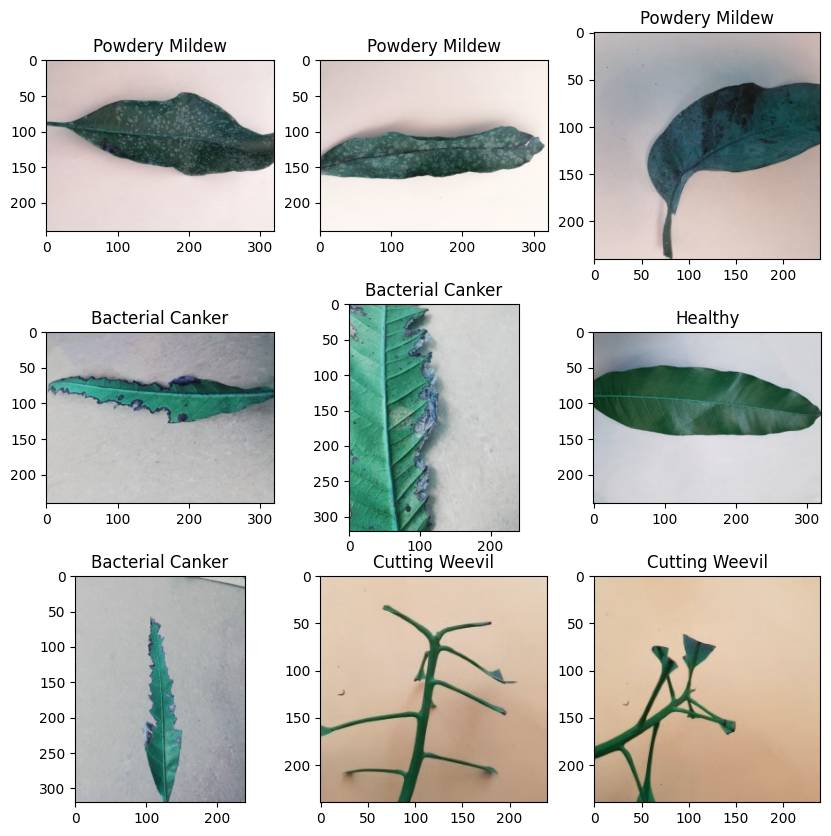

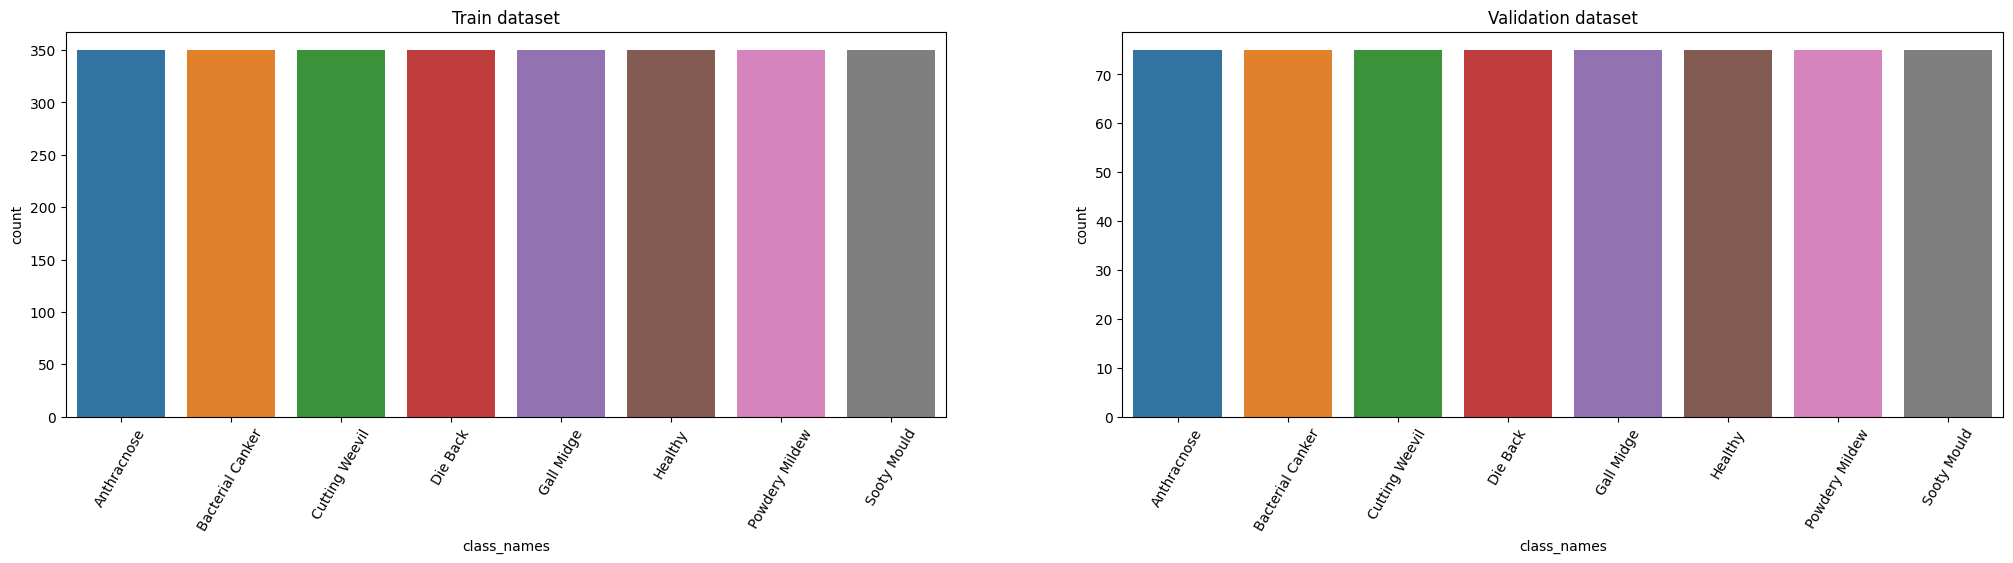

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


(240, 240, 3)

In [ ]:
train_df = create_dataset_df(train_dataset_main, "Train dataset")

valid_df=create_dataset_df(valid_dataset_main, "Validation dataset")

print(f"train samples: {len(train_df)} \n validation samples: {len(valid_df)}")
def vizualizing_images(df,n_rows,n_cols):
    plt.figure(figsize=(10,10))
    for i in range(n_rows*n_cols):
        index = np.random.randint(0, len(df))
        img = cv2.imread(df.img_path[index])
        class_nm = df.class_names[index]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(class_nm)
    plt.show()
vizualizing_images(train_df, 3, 3)

plt.figure(figsize=(25,5))
# train dataset
plt.subplot(1,2,1)
sns.countplot(data=train_df.sort_values("class_names"),x="class_names")
plt.title("Train dataset")
plt.xticks(rotation = 60)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=valid_df.sort_values("class_names"),x="class_names")
plt.title("Validation dataset")
plt.xticks(rotation = 60)

plt.show()

from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_df["class_names"] = Le.fit_transform(train_df["class_names"])

#train_df["class_names"].value_counts()


valid_df["class_names"] = Le.transform(valid_df["class_names"])
#One Hot encoding
train_labels = tf.keras.utils.to_categorical(train_df["class_names"])
valid_labels = tf.keras.utils.to_categorical(valid_df["class_names"])
train_labels[:10]
train_labels.sum(axis=0)

# Compute class weights 

classTotals = train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)
input_image = cv2.imread(train_df.img_path[0])

input_image.shape

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
(64, 96, 96, 3)
(64, 8)
Anthracnose
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
(64, 96, 96, 3)
(64, 8)
Anthracnose
31790344/31790344 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 128)         1622144   
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3, 3, 128)         0         
                                                      

(2800, 600)

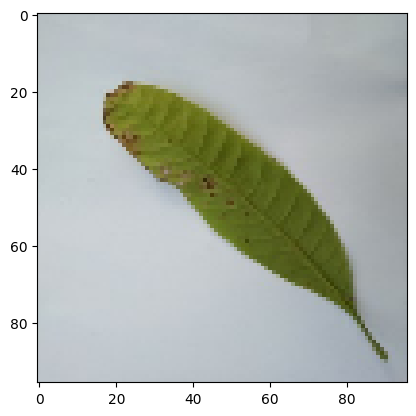

In [ ]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

IMG_SIZE = 96
BATCH_SIZE = 64

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE #to find a good allocation of its CPU budget across all parameters
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat()
    
    return dataset

# Creating Train Dataset object and Verifying it
%time 
train_dataset = get_dataset(train_df["img_path"], train_labels)

#iter() returns an iterator of the given object
#next() returns the next number in an iterator
image , label = next(iter(train_dataset)) 
print(image.shape)
print(label.shape)
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))


%time 
val_dataset = get_dataset(valid_df["img_path"] , valid_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))


# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Dense, Input, GlobalAveragePooling2D


backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

n = 64
model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()

# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)
#
len(train_labels),len(valid_labels)

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2,mode="auto")
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_labels)//BATCH_SIZE,
    epochs=12,
    callbacks=[early_stopping],
    validation_data=val_dataset,
    validation_steps = len(valid_labels)//BATCH_SIZE,
    class_weight=class_weight
)
model.layers[0].trainable = False
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2)
model.summary()


# 2nd Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_labels)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(valid_labels)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
43/43 [==============================] - 288s 6s/step - loss: 1.5396 - accuracy: 0.4811 - precision: 0.9267 - recall: 0.2482 - val_loss: 4.8705 - val_accuracy: 0.5174 - val_precision: 0.6455 - val_recall: 0.5122
Epoch 2/12
43/43 [==============================] - 237s 6s/step - loss: 1.1203 - accuracy: 0.6155 - precision: 0.9000 - recall: 0.4375 - val_loss: 5.5050 - val_accuracy: 0.6580 - val_precision: 0.6962 - val_recall: 0.5729
Epoch 3/12
43/43 [==============================] - 238s 6s/step - loss: 1.0123 - accuracy: 0.6667 - precision: 0.8850 - recall: 0.4949 - val_loss: 1.9328 - val_accuracy: 0.5712 - val_precision: 0.6605 - val_recall: 0.5573
Epoch 4/12
43/43 [==============================] - 239s 6s/step - loss: 0.8265 - accuracy: 0.7591 - precision: 0.8815 - recall: 0.5658 - val_loss: 1.9064 - val_accuracy: 0.6250 - val_precision: 0.6777 - val_recall: 0.6059
Epoch 5/12
43/43 [==============================] - 237s 6s/step - loss: 0.7749 - accuracy: 0.7781 - precisi

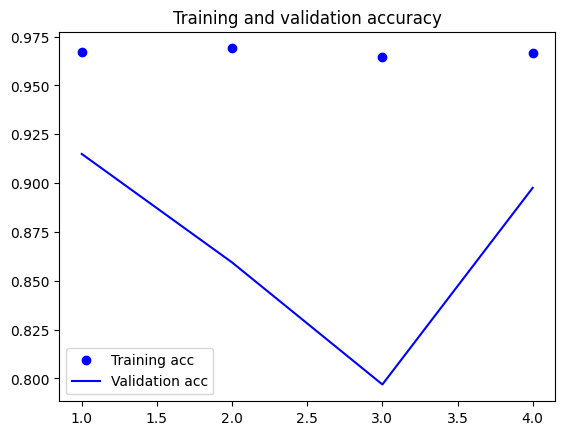

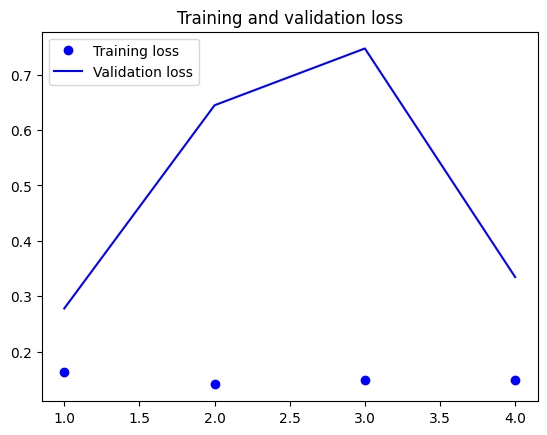

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Reference:**
https://levity.ai/blog/what-is-an-image-classifier
https://developer.apple.com/documentation/createml/creating-an-image-classifier-model
https://www.geeksforgeeks.org/how-to-find-width-and-height-of-an-image-using-python/
https://www.studytonight.com/python-howtos/how-to-unzip-file-in-python#:~:text=To%20unzip%20it%20first%20create,it%20will%20overwrite%20the%20path.
https://www.tensorflow.org/tutorials/images/classification